In [1]:
using Plots
using DataStructures

# 5. Monte Carlo Methods

Instead of computing $v_\pi$ using the given dynamics of an MDP, sample data to _estimate_ $v_\pi$ and use that estimate to perform policy iteration.

## 5.1  Monte Carlo Prediction

We need to learn $v_\pi(s)$ from samples of the MDP process with policy $\pi$.

We distinguish between two ways of estimating $v_\pi(s)$

1. Calculate the average return from trajectories after the _first_ occurrence of state $s$:

$$
\hat{v}_\pi(s) = \frac{1}{N}\sum_{n=1}^N{\sum_{i=k}^{T_n}{\gamma^{i-k}R^n_i}}
$$

Where $T_n$ is the length of episode $n$, and $k$ is the first index such that $S^n_k = s$

2. Calculate the average return from trajectories after _all_ occurences of state $s$

$$
\hat{v}_\pi(s) = \frac{1}{N(s)}\sum_{n,k}\sum_{i=k}^{T_n}{\gamma^{i-k}R^n_i}
$$

We can implement first visit Monte Carlo prediction with the following code

In [2]:
function first_visits(𝓢, S)
    d = Dict()
    for (i, s) in enumerate(S)
        if !haskey(d, s)
            d[s] = i
        end
        
        if length(d) == length(𝓢)
            return d
        end
    end
    return d
end

first_visits (generic function with 1 method)

In [3]:
using DataStructures

function first_visit_mc(𝓢, sampler; γ=1, iterations=1000)
    V = DefaultDict(0)
    N = DefaultDict(0)
    for n in 1:iterations
        S, A, R = sampler()
        visits = first_visits(𝓢, S)
        G = 0
        for i in length(S):-1:1
            G = γ*G + R[i]
            if haskey(visits, S[i]) && visits[S[i]] == i
                N[S[i]] += 1
                V[S[i]] += (1/N[S[i]])*(G - V[S[i]])
            end
        end
    end
    
    return V
end

first_visit_mc (generic function with 1 method)

### Example 5.1: Blackjack

In [4]:
function policy(s)
    hand, dealer, ace = s
    hand < 20 ? :hit : :stick
end

function rollout(π)
    S = Tuple{Int,Int,Bool}[]
    A = Symbol[]
    R = Int64[]
    draw() = min(rand(1:13), 10)
    value(ace, hand) = (ace && hand <= 11) ? hand + 10 : hand 
    dealer = draw()
    hand = [draw(), draw()]
    has_ace = hand[1] == 1 || hand[2] == 1
    hand = sum(hand)
    
    dealer_hand = [dealer, draw()]
    dealer_has_ace = dealer_hand[1] == 1 || dealer_hand[2] == 1
    dealer_hand = sum(dealer_hand)
    while value(dealer_has_ace, dealer_hand) < 17
        card = draw()
        dealer_has_ace = dealer_has_ace || card == 1
        dealer_hand += card
    end
    dealer_total = value(dealer_has_ace, dealer_hand)
    
    # Get up to > 11
    while value(has_ace, hand) <= 11
        card = draw()
        has_ace = has_ace || card == 1
        hand += card
    end
    
    push!(S, (value(has_ace, hand), dealer, has_ace && hand <= 11))
    action = π(S[1])
    push!(A, action)
    while action == :hit && hand <= 21
        card = draw()
        has_ace = has_ace || card == 1
        hand += card
        if hand > 21
            push!(R, -1)
            return S, A, R
        end
        push!(R, 0)
        push!(S, (value(has_ace, hand), dealer, has_ace && hand <= 11))
        action = π(S[end])
        push!(A, action)
    end
    player_total = value(has_ace, hand)

    if (hand > 21 && dealer_hand > 21)
        push!(R, 0)
    elseif hand > 21
        push!(R, -1)
    elseif dealer_hand > 21
        push!(R, 1)
    elseif player_total == dealer_total
        push!(R, 0)
    elseif player_total < dealer_total
        push!(R, -1)
    else player_total > dealer_total
        push!(R, 1)
    end

    return S, A, R
end

rollout (generic function with 1 method)

In [5]:
rollout(policy)

(Tuple{Int64, Int64, Bool}[(13, 10, 0), (20, 10, 0)], [:hit, :stick], [0, -1])

In [6]:
𝓢 = [ (value, dealer, usable_ace) for value in 12:21, dealer in 1:10, usable_ace in [true, false]]

V1e4 = first_visit_mc(𝓢, () -> rollout(policy); γ=1, iterations=10_000)
V5e5 = first_visit_mc(𝓢, () -> rollout(policy); γ=1, iterations=500_000)

DefaultDict{Any, Any, Int64} with 200 entries:
  (20, 8, false)  => 0.793085
  (16, 10, false) => -0.671412
  (16, 2, false)  => -0.65932
  (19, 3, true)   => -0.427391
  (15, 9, false)  => -0.611765
  (19, 10, false) => -0.740764
  (19, 2, false)  => -0.72176
  (17, 3, false)  => -0.696385
  (17, 9, true)   => -0.365253
  (13, 7, true)   => -0.141649
  (12, 6, true)   => -0.171806
  (18, 10, true)  => -0.458277
  (18, 2, true)   => -0.406869
  (20, 8, true)   => 0.784355
  (16, 10, true)  => -0.417856
  (16, 2, true)   => -0.361199
  (20, 7, false)  => 0.774291
  (15, 3, false)  => -0.626675
  (15, 9, true)   => -0.252525
  (19, 10, true)  => -0.469322
  (19, 2, true)   => -0.384977
  (17, 3, true)   => -0.423704
  (13, 9, false)  => -0.535662
  (17, 10, false) => -0.704393
  (17, 2, false)  => -0.686378
  ⋮               => ⋮

In [7]:
ace_V1e4 = [ V1e4[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_V1e4 = [ V1e4[(i, j, false)] for i in 12:21, j in 1:10 ]
ace_V5e5 = [ V5e5[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_V5e5 = [ V5e5[(i, j, false)] for i in 12:21, j in 1:10 ];

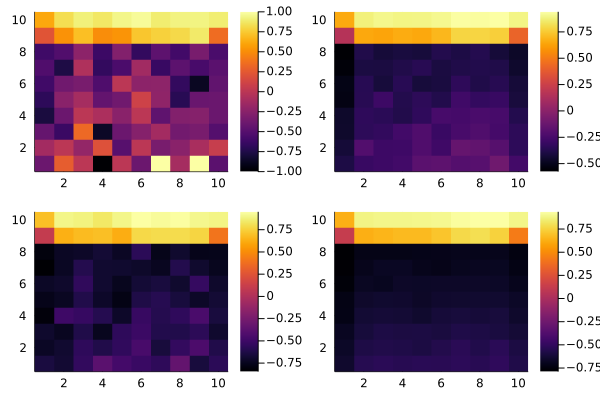

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423


In [8]:
p1 = heatmap(ace_V1e4)
p2 = heatmap(noace_V1e4)
p3 = heatmap(ace_V5e5)
p4 = heatmap(noace_V5e5)

plot(p1, p3, p2, p4, layout=(2,2))

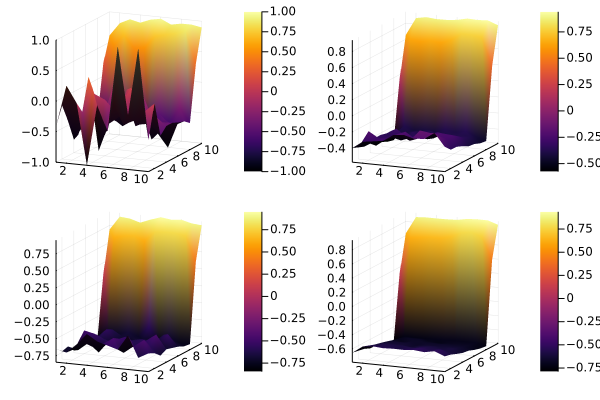

In [9]:
p1 = surface(ace_V1e4)
p2 = surface(noace_V1e4)
p3 = surface(ace_V5e5)
p4 = surface(noace_V5e5)

plot(p1, p3, p2, p4, layout=(2,2))

> _Exercise 5.1_ Consider the diagrams on the right in Figure 5.1. Why does the estimated value function jump up for the last two rows in the rear? Why does it drop off for the whole last row on the left? Why are the frontmost values higher in the upper diagrams than in the lower?

The estimated value function jumps for the last two rows since those two rows represent relatively high scores compared to the average dealer score, and additionally the policy "sticks" for these values, meaning we are likely to achieve those scores than busting.

The drop off on the left is because the dealer possesses an ace, which is a more valuable card since it can be used as either an 11 or a 1.

The value of the states in the bottom half of the figure are for the same reason. Having an ace allows you to "hit" more with less of a chance of busting.

> _Exercise 5.2_ Suppose every-visit MC was used instead of first-visit MC on the blackjack task. Would you expect the results to be very different? Why or why not?

I would not expect every-visit MC to be very different from the first-visit MC results. This is because the value of any state, as we have set it up here, is not affected by it's location in the sequence.

> _Exercise 5.3_ What is the backup diagram for Monte Carlo estimation of $q_\pi$?

The backup diagram for Monte Carlo $q_\pi$ estimation would be the same as the backup diagram for state-value estimation, since in either case we start with a particular state and action. In order to illustrate this one could somehow indicate that the initial state _and_ action are being evaluated, rather than just the particular state, perhaps by surrounding the state and action with a box.

> _Exercise 5.4_ The pseudocode for Monte Carlo ES is inefficient because, for each state–action pair, it maintains a list of all returns and repeatedly calculates their mean. It would be more efficient to use techniques similar to those explained in Section 2.4 to maintain just the mean and a count (for each state–action pair) and update them incrementally. Describe how the pseudocode would be altered to achieve this.

This can be achieved by simply mainting the current average values $Q(s, a)$, and the visit count to each state-action pair. Instead of recomputing the average, we compute:

$$
Q(s, a) \gets Q(s, a) + \frac{1}{N(s, a)}(G - Q(s, a))
$$

In [10]:
function first_visits(𝓢, 𝓐, S, A)
    visits = Dict()
    for i in eachindex(S)
        if !haskey(visits, (S[i], A[i]))
            visits[(S[i], A[i])] = i
        end
        
        if length(visits) == length(𝓢)*length(𝓐)
            return visits
        end
    end
    return visits
end

function monte_carlo_es(𝓢, 𝓐, init_sampler, sampler, π_init; γ=1, iterations=10000)
    π_dict = π_init
    π(s) = π_dict[s]
    Q = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    N = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    
    for i in 1:iterations
        s0, a0 = init_sampler()
        S, A, R = sampler(π, s0, a0)
        visits = first_visits(𝓢, 𝓐, S, A)
        G = 0
        for i in length(S):-1:1
            G = γ*G + R[i]
            if visits[(S[i], A[i])] == i
                N[S[i], A[i]] += 1
                Q[S[i], A[i]] += 1/(N[S[i], A[i]]) * (G - Q[S[i], A[i]])
                π_dict[S[i]] = argmax(a -> Q[S[i], a], 𝓐)
            end
        end
    end
    
    return Q, π_dict
end

π_init = Dict(s => policy(s) for s in 𝓢)
𝓐 = [:hit, :stick]

init_sampler() = (rand(𝓢), rand(𝓐))

function rollout_es(π, s0, a0)
    S = Tuple{Int,Int,Bool}[]
    A = Symbol[]
    R = Int64[]
    draw() = min(rand(1:13), 10)
    value(ace, hand) = (ace && hand <= 11) ? hand + 10 : hand 
    
    init_value, dealer, usable_ace = s0
    if usable_ace
        hand = init_value - 10
    else
        hand = init_value
    end
    has_ace = usable_ace
    
    dealer_hand = [dealer, draw()]
    dealer_has_ace = dealer_hand[1] == 1 || dealer_hand[2] == 1
    dealer_hand = sum(dealer_hand)
    while value(dealer_has_ace, dealer_hand) < 17
        card = draw()
        dealer_has_ace = dealer_has_ace || card == 1
        dealer_hand += card
    end
    dealer_total = value(dealer_has_ace, dealer_hand)
    
    push!(S, s0)
    push!(A, a0)
    
    action = a0
    while action == :hit && hand <= 21
        card = draw()
        has_ace = has_ace || card == 1
        hand += card
        if hand > 21
            push!(R, -1)
            return S, A, R
        end
        push!(R, 0)
        push!(S, (value(has_ace, hand), dealer, has_ace && hand <= 11))
        action = π(S[end])
        push!(A, action)
    end
    player_total = value(has_ace, hand)

    if (hand > 21 && dealer_hand > 21)
        push!(R, 0)
    elseif hand > 21
        push!(R, -1)
    elseif dealer_hand > 21
        push!(R, 1)
    elseif player_total == dealer_total
        push!(R, 0)
    elseif player_total < dealer_total
        push!(R, -1)
    else player_total > dealer_total
        push!(R, 1)
    end

    return S, A, R
end

rollout_es (generic function with 1 method)

In [11]:
Q, π_star = monte_carlo_es(𝓢, 𝓐, init_sampler, rollout_es, π_init; γ=1, iterations=5e5);

In [12]:
V = Dict(s => Q[s, π_star[s]] for s in 𝓢)

Dict{Tuple{Int64, Int64, Bool}, Float64} with 200 entries:
  (20, 8, 0)  => 0.786496
  (16, 10, 0) => -0.565275
  (19, 3, 1)  => 0.407016
  (16, 2, 0)  => -0.288302
  (15, 9, 0)  => -0.489627
  (19, 10, 0) => -0.0235611
  (19, 2, 0)  => 0.379255
  (17, 9, 1)  => -0.191338
  (13, 7, 1)  => 0.101048
  (17, 3, 0)  => -0.0955525
  (12, 6, 1)  => 0.181741
  (18, 10, 1) => -0.203791
  (18, 2, 1)  => 0.108028
  (20, 8, 1)  => 0.810488
  (16, 10, 1) => -0.263251
  (16, 2, 1)  => -0.0557888
  (20, 7, 0)  => 0.77084
  (15, 9, 1)  => -0.125398
  (15, 3, 0)  => -0.255398
  (19, 10, 1) => 8.78204e-18
  (19, 2, 1)  => 0.368997
  (17, 3, 1)  => 0.0350389
  (13, 9, 0)  => -0.391518
  (17, 10, 0) => -0.49476
  (17, 2, 0)  => -0.16373
  ⋮           => ⋮

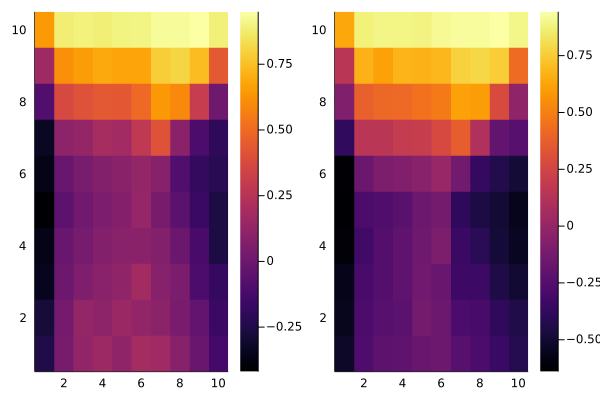

In [13]:
ace_V = [ V[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_V = [ V[(i, j, false)] for i in 12:21, j in 1:10 ];

p3 = heatmap(ace_V)
p4 = heatmap(noace_V)

plot(p3, p4, layout=(1,2))

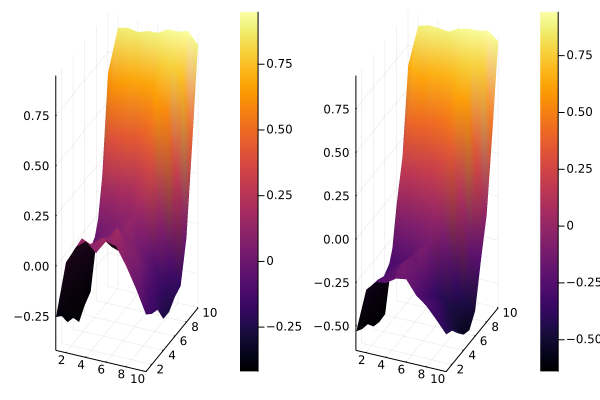

In [14]:
p1 = surface(ace_V)
p2 = surface(noace_V)

plot(p1, p2, layout=(1, 2))

In [15]:
ace_π = [ π_star[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_π = [ π_star[(i, j, false)] for i in 12:21, j in 1:10 ];

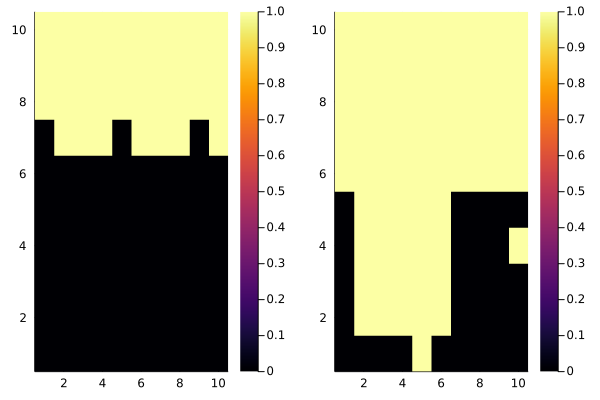

In [16]:
p1 = heatmap(ace_π .== :stick)
p2 = heatmap(noace_π .== :stick)

plot(p1, p2, layout=(1, 2))

In [17]:
function monte_carlo_es_epsilon_greedy(𝓢, 𝓐, sampler, π_init; γ=1, iterations=10000, ε=0.05)
    π_dict = π_init
    π(s) = rand() < ε ? rand(𝓐) : π_dict[s]
    Q = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    N = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    
    for i in 1:iterations
        S, A, R = sampler(π)
        visits = first_visits(𝓢, 𝓐, S, A)
        G = 0
        for i in length(S):-1:1
            G = γ*G + R[i]
            if visits[(S[i], A[i])] == i
                N[S[i], A[i]] += 1
                Q[S[i], A[i]] += 1/(N[S[i], A[i]]) * (G - Q[S[i], A[i]])
                π_dict[S[i]] = argmax(a -> Q[S[i], a], 𝓐)
            end
        end
    end
    
    return Q, π_dict
end

monte_carlo_es_epsilon_greedy (generic function with 1 method)

In [18]:
Q, π_dict = monte_carlo_es_epsilon_greedy(𝓢, 𝓐, rollout, π_init; γ=1, iterations=5e6)

(Dict{Tuple{Tuple{Int64, Int64, Bool}, Symbol}, Float64}(((14, 7, 0), :hit) => -0.33703615138801385, ((16, 7, 0), :stick) => -0.4613333333333331, ((19, 8, 1), :stick) => 0.6048114434330297, ((19, 5, 1), :hit) => 0.13989637305699493, ((20, 9, 0), :hit) => -0.8570496083550911, ((15, 10, 1), :hit) => -0.23040638606676384, ((19, 7, 0), :stick) => 0.6139688752213204, ((15, 2, 1), :hit) => -0.004227164124241891, ((13, 3, 1), :hit) => 0.07702552719200892, ((17, 8, 0), :stick) => -0.380931757718244…), Dict{Tuple{Int64, Int64, Bool}, Symbol}((20, 8, 0) => :stick, (16, 10, 0) => :stick, (19, 3, 1) => :stick, (16, 2, 0) => :stick, (13, 6, 1) => :hit, (15, 9, 0) => :hit, (19, 10, 0) => :stick, (19, 2, 0) => :stick, (17, 9, 1) => :hit, (13, 7, 1) => :hit…))

In [19]:
ace_π_eps = [ π_star[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_π_eps = [ π_star[(i, j, false)] for i in 12:21, j in 1:10 ];

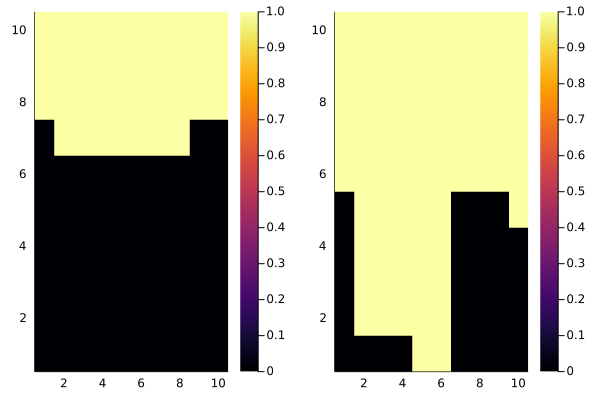

In [20]:
p1 = heatmap(ace_π_eps .== :stick)
p2 = heatmap(noace_π_eps .== :stick)

plot(p1, p2, layout=(1, 2))

In [30]:
using Distributions

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1423


In [31]:
u = Uniform(0, 5)
n = Normal()

Normal{Float64}(μ=0.0, σ=1.0)

In [51]:
sample_n = rand(n, 10_000_000);

In [52]:
mean(pdf.(u, sample_n) ./ pdf.(n, sample_n) .* sample_n)

2.5161477946181194

$$
\mathbb{E}[X] = \mathbb{E}_{y\sim\dots}\bigg[\frac{P(X)}{P(Y)}X\bigg] = \int_{Y}{p(y)\frac{p(x)}{p(y)}x\mathrm{d}x} = \int{xp(x)\mathrm{d}x}
$$

## 5.5 Importance Sampling

> _Exercise 5.5_ Consider an MDP with a single nonterminal state and a single action that transitions back to the nonterminal state with probability p and transitions to the terminal state with probability $1 - p$. Let the reward be $+1$ on all transitions, and let $\gamma = 1$. Suppose you observe one episode that lasts 10 steps, with a return of 10. What are the first-visit and every-visit estimators of the value of the nonterminal state?

The first-visit estimator will be $10$, since the expected future reward from the _first_ visit to the nonterminal state resulted in a total return of $10$. However, the every-visit estimator will estimate the value of the state as:

$$
V(s) = \frac{1}{10}\sum_{i=1}^{10}{i} = 5.5
$$

Since it observes each of $1, 2\dots10$ as a return for the nonterminal state.

> _Exercise 5.6_ What is the equation analagous to (5.6) for _action_ values $Q(s, a)$ instead of state values $V(s)$, again given returns generated using $b$?

$$
Q(s, a) = \frac{\sum_{t\in\mathcal{T}(s, a)}\rho_{t+1:T-1}G_t}{\sum_{t\in\mathcal{T}(s, a)}{\rho_{t+1:T-1}}}
$$

> _Exercise 5.7_ In learning curves such as those shown in Figure 5.3 error generally decreases with training, as indeed happened for the ordinary importance-sampling method. But for the weighted importance-sampling method error first increased and then decreased. Why do you think this happened?

> _Exercise 5.8_ The results with Example 5.5 and shown in Figure 5.4 used a first-visit MC method. Suppose that instead an every-visit MC method was used on the same problem. Would the variance of the estimator still be infinite? Why or why not?

## 5.6 Incremental Implementation

> _Exercise 5.9_ Modify the algorithm for first-visit MC policy evaluation (Section 5.1) to use the incremental implementation for sample averages described in Section 2.4.

✅

> _Exercise 5.10_ Derive the weighted-average update rule (5.8) from (5.7). Follow the pattern of the derivation of the unweighted rule (2.3).

Note that $C_n = \sum_{k=1}^{n}{W_k}$

$$
\begin{align*}
V_{n+1} &= \frac{\sum_{k=1}^{n}{W_k G_k}}{\sum_{k=1}^{n}{W_k}}\\\\
&= \frac{1}{\sum_{k=1}^{n}{W_k}}\big(W_n G_n + \sum_{k=1}^{n-1}{W_k G_k}\big)\\\\
&= \frac{1}{C_n}\big(W_n G_n + C_{n-1}V_n\big)\\\\
&= \frac{W_n G_n}{C_n} + \frac{C_n - W_n}{C_n}V_n\\\\
&= \frac{W_n G_n}{C_n} + V_n - \frac{W_n}{C_n}V_n\\\\
&= V_n + \frac{W_n}{C_n}(G_n - V_n)
\end{align*}
$$

## 5.7 Off-policy Monte Carlo Control

> _Exercise 5.11_ In the boxed algorithm for off-policy MC control, you may have been expecting the $W$ update to have involved the importance-sampling ratio $\frac{\pi(A_t|S_t)}{b(A_t|S_t)}$, but instead it involves $\frac{1}{b(A_t|S_t)}$. Why is this nevertheless correct?

Because of the guard before this line, we know that $\pi(S_t) = A_t$. Conceptually, this is identical to a distribution $\pi(A_t | S_t) = 1$, so this component of the importance sampling ratio will always be $\frac{\pi(A_t | S_t}{b(A_t | S_t)} = \frac{1}{b(A_t | S_t)}$.

> _Exercise 5.12: Racetrack (programming)_ Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components. Each may be changed by +1, -1, or 0 in each step, for a total of nine ($3 \times 3$) actions. Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. The rewards are -1 for each step until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments. Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

In [21]:
𝓐 = [ (i, j) for i in -1:1, j in -1:1]

3×3 Matrix{Tuple{Int64, Int64}}:
 (-1, -1)  (-1, 0)  (-1, 1)
 (0, -1)   (0, 0)   (0, 1)
 (1, -1)   (1, 0)   (1, 1)

In [22]:
function rollout_racecar(course, policy)
    starting, finishing, boundary = course
    locations = cat(starting, finishing, boundary; dims=1)
    velocities = [ (i, j) for i in 0:4, j in 0:4 if i != 0 ||  j != 0 ]
    
    𝓢 = cat(
        [ (location..., velocity...) for location in locations, velocity in velocities if true],
        [ (location..., 0, 0) for location in starting ];
        dims=1
    )
    
    S = []
    A = []
    R = []
    S_current = (rand(starting)..., 0, 0)
    A_current = policy(S_current)
    R_current = -1
    done = false
    while !done
        push!(S, S_current)
        push!(A, A_current)
        push!(R, -1)
        
        x, y, vx, vy = S_current
        nx = x + vx
        ny = y + vy

        ax, ay = A_current
        nvx = clamp(vx + ax, 0, 4)
        nvy = clamp(vy + ay, 0, 4)
            
        if (nx, ny) ∉ locations
            println("Restarting")
            nx, ny = rand(starting)
            nvx, nvy = (0, 0)
        end

        if vx != 0
            for xp in x:nx
                yp = vx == 0 ? y : y + floor((vy/vx)*(xp - x))
                if (xp, yp) ∈ finishing
                    println("Finishing")
                    done = true
                end
                if (xp, yp) ∉ locations
                    println("Restarting")
                    nx, ny = rand(starting)
                    nvx, nvy = (0, 0)
                end
            end
        elseif vy != 0
            for yp in y:ny
                if (x, yp) ∈ finishing
                    println("Finishing")
                    done = true
                end
                if (x, yp) ∉ locations
                    println("Restarting")
                    nx, ny = rand(starting)
                    nvx, nvy = (0, 0)
                end
            end
        end
        S_current = (nx, ny, nvx, nvy)
        A_current = policy(S_current)
    end
    
    return S, A, R
end

rollout_racecar (generic function with 1 method)

In [23]:
function racer_policy(s)
    x, y, vx, vy = s
    if rand() < 0.1
        return rand(𝓐)
    elseif y > 17
        return (1, -1)
    else
        return (0, 1)
    end
end

racer_policy (generic function with 1 method)

In [24]:
function racer_prob(a, s)
    x, y, vx, vy = s
    ap = y > 17 ? (1, -1) : (0, 1)
    if a == ap
        return 1 - 0.1 + 0.1/length(𝓐)
    else
        return 0.1 / length(𝓐)
    end
end

racer_prob (generic function with 1 method)

In [25]:
course1 = (
    [(x, 1) for x in 4:9],
    [(17, y) for y in 27:32],
    cat(
        [(x, y) for x in 4:9, y in 2:32 if true],
        [(x, y) for x in 10:16, y in 27:32 if true],
        [(3, y) for y in 4:31],
        [(2, y) for y in 11:29],
        [(1, y) for y in 19:28],
        [(10, 26)]; dims = 1
    )
)

([(4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)], [(17, 27), (17, 28), (17, 29), (17, 30), (17, 31), (17, 32)], [(4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (4, 3), (5, 3), (6, 3), (7, 3)  …  (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (10, 26)])

In [26]:
S, A, R = rollout_racecar(course1, racer_policy)

Restarting
Restarting
Finishing


(Any[(7, 1, 0, 0), (7, 1, 0, 1), (7, 2, 0, 2), (7, 4, 0, 3), (7, 7, 0, 4), (7, 11, 0, 4), (7, 15, 0, 4), (7, 19, 0, 4), (7, 23, 1, 4), (8, 27, 2, 3)  …  (7, 2, 0, 2), (7, 4, 0, 3), (7, 7, 0, 4), (7, 11, 0, 4), (7, 15, 0, 4), (7, 19, 0, 4), (7, 23, 1, 3), (8, 26, 2, 2), (10, 28, 3, 1), (13, 29, 4, 0)], Any[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (1, 0), (1, -1), (1, -1)  …  (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1)], Any[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1  …  -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [27]:
function off_policy_mc_control(𝓢, 𝓐, policy, b, γ, iterations, course)
    Q = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    C = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    π_dict = Dict(s => rand(𝓐) for s in 𝓢)
    
    for n in 1:iterations
        G = 0
        W = 1
        
        S, A, R = rollout_racecar(course, policy)
        for t in length(S):-1:1
            G = γ*G + R[t]
            C[(S[t], A[t])] += W
            Q[(S[t], A[t])] += W/C[(S[t],A[t])] * (G - Q[(S[t], A[t])])
            π_dict[S[t]] = argmax(a -> Q[(S[t], a)], 𝓐)
            if A[t] != π_dict[S[t]]
                break
            end
            W *= 1/b(A[t], S[t])
        end
    end
end

off_policy_mc_control (generic function with 1 method)

In [28]:
starting, finishing, boundary = course1
locations = cat(starting, finishing, boundary; dims=1)
velocities = [ (i, j) for i in 0:4, j in 0:4 if i != 0 ||  j != 0 ]

𝓢 = cat(
    [ (location..., velocity...) for location in locations, velocity in velocities if true],
    [ (location..., 0, 0) for location in starting ];
    dims=1
)

7158-element Vector{NTuple{4, Int64}}:
 (4, 1, 1, 0)
 (5, 1, 1, 0)
 (6, 1, 1, 0)
 (7, 1, 1, 0)
 (8, 1, 1, 0)
 (9, 1, 1, 0)
 (17, 27, 1, 0)
 (17, 28, 1, 0)
 (17, 29, 1, 0)
 (17, 30, 1, 0)
 (17, 31, 1, 0)
 (17, 32, 1, 0)
 (4, 2, 1, 0)
 ⋮
 (1, 24, 4, 4)
 (1, 25, 4, 4)
 (1, 26, 4, 4)
 (1, 27, 4, 4)
 (1, 28, 4, 4)
 (10, 26, 4, 4)
 (4, 1, 0, 0)
 (5, 1, 0, 0)
 (6, 1, 0, 0)
 (7, 1, 0, 0)
 (8, 1, 0, 0)
 (9, 1, 0, 0)

In [29]:
off_policy_mc_control()

LoadError: MethodError: no method matching off_policy_mc_control()
[0mClosest candidates are:
[0m  off_policy_mc_control([91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m) at In[27]:1